In [1]:
#Imports
import pandas as pd
import numpy as np
from keras.applications.vgg19 import VGG19

Using TensorFlow backend.


In [78]:
#Importing the dataset into train test and validation directories
train_path='../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_path='../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_path='../input/chest-xray-pneumonia/chest_xray/chest_xray/val'

IMAGE_SIZE=[224,224]

In [79]:
#Data Preprocessing
from keras.preprocessing.image import ImageDataGenerator
#Train Generator
train_gen=ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)
#Test Generator
test_gen=ImageDataGenerator(rescale=1./255)

#Validation Generator
val_gen=ImageDataGenerator(rescale=1./255)

In [80]:
#Generating Training data
train_images=train_gen.flow_from_directory(train_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [81]:
#Generating Testing data
test_images=test_gen.flow_from_directory(test_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 624 images belonging to 2 classes.


In [82]:
#Generating Validation data
val_images=val_gen.flow_from_directory(val_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 16 images belonging to 2 classes.


In [83]:
#Model based imports
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
import matplotlib.pyplot as plt


In [84]:
#Add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#Freeze Current Weights
for layer in vgg.layers:
    layer.trainable = False

In [85]:
#VGG19 model summary
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [86]:
#Useful for getting number of classes
from glob import glob
folders = glob(train_path+'/*')
folders

['../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA']

In [87]:
#Adding our layers to the vgg19 model
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

#Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

#Our model Summary
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [88]:
#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [89]:
# Setting CSV Logger
#Store Model Params in log
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('log.csv', separator=',',append=False)

In [90]:
#Fitting the model
hist=model.fit_generator(train_images,
                        steps_per_epoch=150,
                        epochs=5,
                        validation_data=test_images,
                        validation_steps=20,
                        callbacks=[csv_logger])

Epoch 1/5
150/150 [==============================] - 118s 786ms/step - loss: 0.3505 - accuracy: 0.8919 - val_loss: 0.8244 - val_accuracy: 0.8862
Epoch 2/5
150/150 [==============================] - 116s 774ms/step - loss: 0.1337 - accuracy: 0.9502 - val_loss: 0.6638 - val_accuracy: 0.9087
Epoch 3/5
150/150 [==============================] - 114s 761ms/step - loss: 0.1094 - accuracy: 0.9563 - val_loss: 0.0130 - val_accuracy: 0.9071
Epoch 4/5
150/150 [==============================] - 114s 759ms/step - loss: 0.1089 - accuracy: 0.9596 - val_loss: 0.3536 - val_accuracy: 0.9071
Epoch 5/5
150/150 [==============================] - 114s 762ms/step - loss: 0.1523 - accuracy: 0.9452 - val_loss: 0.1768 - val_accuracy: 0.8734


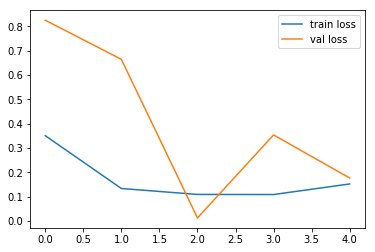

<Figure size 432x288 with 0 Axes>

In [91]:
# Plot loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

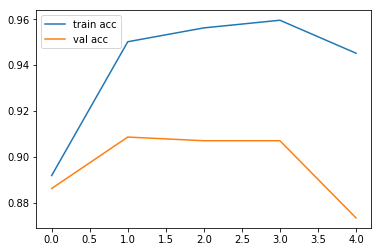

<Figure size 432x288 with 0 Axes>

In [95]:
#Plot accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [97]:
# import the modules we'll need to download the log.csv file
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = pd.read_csv('log.csv')

# create a link to download the dataframe
create_download_link(df)

# ↓ ↓ ↓  Yay, download link! ↓ ↓ ↓

In [ ]:
#Save the model
model.save('vgg19_model.h5')